# Environment setting

### 후처리, 시각화, 계산을 편하게 하기 위한 준비 코드.

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import tempfile
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import path
import MP.read_blocks as rb
from MP.mat.mech import FlowCurve as FC
from glob import glob
from scipy import optimize
import subprocess
import multiprocessing
import shutil
import tempfile
import os
from scipy import interpolate
from subprocess import PIPE
from TX import cmb
from TX import upf
from TX import sym
import time
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
interp1d=interpolate.interp1d
#주어진 행과 열에 맞춰 여러 개의 서브플롯을 생성하고, 이를 포함하는 matplotlib 그림 객체와 서브플롯 객체 배열을 반환하는 함수
def gen_fig(nrows=3,ncols=3,colsize=2.5,rowsize=2.,**kwargs):
    """
    matplotlib의 figure와 axes 배열을 생성하는 함수

    Arguments
    ---------
    nrows   : subplot의 행 개수
    ncols   : subplot의 열 개수
    colsize : 각 열의 너비 (인치 단위)
    rowsize : 각 행의 높이 (인치 단위)
    kwargs  : plt.subplots에 추가로 넘길 옵션들

    Returns
    ---------
    fig   : 생성된 matplotlib figure 객체
    axes  : (nrows, ncols) 배열 형태의 axes 객체들
    """  
    from matplotlib.gridspec import GridSpec
    import matplotlib.pyplot as plt
    gs=GridSpec(nrows=nrows,ncols=ncols,**kwargs)
    fig=plt.figure(figsize=(colsize*ncols,rowsize*nrows))
    axes=np.empty((nrows,ncols),dtype='object')
    for i in range(nrows):
        for j in range(ncols):
            ax=fig.add_subplot(gs[i,j])
            axes[i,j]=ax
    return fig,axes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### gen_fig 코드는 무엇인가?

In [21]:
help(gen_fig)

Help on function gen_fig in module __main__:

gen_fig(nrows=3, ncols=3, colsize=2.5, rowsize=2.0, **kwargs)
    ## 서브플롯들을 어떻게 배치할지를 결정하는 핵심적인 역할
    # nrows와 ncols를 사용해 서브플롯의 행과 열을 정의하고, 추가적인 설정을 **kwargs로 받아서 서브플롯 배치를 유연하게 처리



#### 다음 코드는 주로 결정학적 텍스처 분석을 위한 것으로, 오일러 각도를 이용해서 IPF(Inverse Pole Figure) 색상을 시각화하는 데 사용. 데이터를 불러와 오일러 각도를 기반으로 특정 방향의 결정학적 색상을 계산, 계산 후에 도출한 색상 맵과 위치 좌표로 IPF 시각화. 재료의 미세조직 정보 시각화에 활용. 

In [ ]:
"주어진 xs 배열에서 고유값을 추출하고, 그 값들의 차이를 계산하여 일정한 간격(dx)이 있는지 확인하는 함수, 만약 일정하지 않으면 오류를 발생시킴"
def find_dx(xs):
    Xs=np.unique(xs)
    dXs=np.diff(Xs)
    dx=np.unique(dXs)
    if len(dx)!=1:
        raise IOError("** Unexpected behavior")
    """"
    주어진 1차원 배열 xs에서 인접 원소 간 간격(dx)을 계산하여 반환

    Arguments
    ---------
    xs : 1차원 배열 (숫자 리스트나 numpy 배열)

    Returns
    ---------
    dx : 인접 원소 간 간격 중 첫 번째 값
    """
    return dx[0]

"두 숫자 a와 b에 대해 **몫(quotient)**과 **나머지(remainder)**를 구하는 함수"
def get_quot_rem(a,b):
    """
    Getting quotient and remainder of a / b

    Arguments
    ---------
    a
    b

    Returns
    -------
    quotient and remainder of a/b
    """
    return int(a/b), a%b
    #sol=int(a/b)
    #rem=a%b
    #print(sol*b+rem)
    #print(a)

def read_euler_from_array(dat_ori,nline_x=0,nline_y=0):
    """
    from dat_ori,
    griddata of phi1, phi, phi2 with X,Y coordinates

    Returns
    -------
    nline_x,nline_y,X,Y,phi1,Phi,phi2,x0,x1,y0,y1,euler_angles
    """
    ## x및 y좌표 최소 및 최대값을 각각 (x0,x1), (y0,y1)의 '이름'(name)으로 저장
    x=dat_ori[3]
    y=dat_ori[4]
    x0,x1=x.min(),x.max()
    y0,y1=y.min(),y.max()

    if nline_x*nline_y==0:
        dx=find_dx(x)
        dy=find_dx(y)
        nline_x=int((x1-x0)/dx)+1
        nline_y=int((y1-y0)/dy)+1
    print(f'dat_ori.shape: {dat_ori.shape}')
    print(f'x range: {x0} - {x1}')
    print(f'y range: {y0} - {y1}')
    print(f'nline_x: {nline_x}\nnline_y: {nline_y}')
    xs=np.linspace(x0,x1,nline_x)
    ys=np.linspace(y0,y1,nline_y)

    ## meshgrid
    X,Y=np.meshgrid(xs,ys)#,dtype='float16')
    points=np.array([x,y]).T
    ## meshgrid에 'nearest' interpolation 적용하여 (phi1, Phi, phi2)
    ## map 만들기.
    phi1=griddata(points,dat_ori[0],(X,Y),method='nearest') #phi1
    Phi =griddata(points,dat_ori[1],(X,Y),method='nearest') #Phi
    phi2=griddata(points,dat_ori[2],(X,Y),method='nearest') #phi2
    ## 각 Euler angle map의 color map 그리기
    euler_angles=np.array([phi1,Phi,phi2])
    return nline_x,nline_y,X,Y,phi1,Phi,phi2,x0,x1,y0,y1,euler_angles

def get_ipf_color(phi1s,Phis,phi2s,pole_sa=[1,0,0],
                  fnsx='/Users/parkjaeseob/texture3/eddq.sx'):
    """
    Euler 각도 배열에서 IPF(inverse pole figure) 색상을 계산하여 반환

    Arguments
    ---------
    phi1s: 1D array of phi1 angle
    Phis : 1D array of Phi angle
    phi2s: 1D array of phi2 angle
    pole_sa : inverse pole (referred in sample axes)
    fnsx    : (E)VPSC's single crystal file, from which the details of
             crystal axes are given ('csym', 'cdim', and 'cang')

    Returns
    -------
    flt : fundamental triangle 내에 위치하는 점들의 불리언 배열 필터
    rgbs : 각 각도에 대응하는 RGB 색상 배열
    """
    time_stamps=[]
    time_stamps.append(time.perf_counter())
    tiny = 1e-10

    ## generate grain arrays in the dimension of (NGR, 4)
    grains=np.zeros((len(phi1s),4))
    grains[:,0]=phi1s[::]
    grains[:,1]=Phis[::]
    grains[:,2]=phi2s[::]
    grains[:,3]=1./len(phi1s)

    ## Getting the inverse pole figure boundary
    rst = upf.get_ipf_boundary(fnsx=fnsx,nres=100)
    triangle, a, b, c = rst[0],rst[1],rst[2],rst[3] #, at,bt,ct
    csym,cang,cdim=sym.read_fnsx(fnsx)

    ## 1D array of all projected poles:
    ## projected_poles in the dimension of (NGR,nsymopx2,3)
    XY, WGT, COL, projected_poles, nsymopx2 = upf.cells_pf(
        iopt=1,proj='ipf',pole=pole_sa,csym=csym,
        cang=cang,cdim=cdim,grains=grains)
    #time.perf_counter()
    time_stamps.append(time.perf_counter())

    ## First filter within the radius
    ## Within the fundamental triangle only.
    p=path.Path(triangle[:,:].T)
    flt=p.contains_points(XY)
    XY=XY[flt,:]
    projected_poles=projected_poles[flt,:]
    projected_poles[:,2]=projected_poles[:,2]*-1 ## inversion of z

    a=np.array(a)
    b=np.array(b)
    c=np.array(c)
    color_mapper = get_color_mapper(a,b,c)

    time_stamps.append(time.perf_counter())

    #print(f'shape of projected poles: {projected_poles.shape}')
    #print(f'color_mapper shape:, {color_mapper.shape}')
    rgbs = get_rgb_from_invp(projected_poles,color_mapper)
    time_stamps.append(time.perf_counter())
    return flt,rgbs

#결정 방향 벡터를 RGB 색상으로 변환하는 기준축(변환 행렬)을 만드는 함수
def get_color_mapper(a,b,c):
    """
    Generate 'color mapper' (3x3 matrix) that maps cartesian vectors,
    a, b, and c, to the three corners of Red, Green, Blue color space.

    Arguments
    ---------
    a
    b
    c

    Return
    ------
    color_mapper <3,3> that maps <poles> to <rgbs>
    """
    na=a/np.sqrt((a**2).sum())
    nb=b/np.sqrt((b**2).sum())
    nc=c/np.sqrt((c**2).sum())

    ## Mapping matrix that maps a pole to the three
    # color corners of RGB combinations
    color_corners=np.identity(3)
    color_corners[:,0]=na[:]
    color_corners[:,1]=nb[:]
    color_corners[:,2]=nc[:]
    color_mapper = np.linalg.inv(color_corners)
    return color_mapper

#결정 방향 → RGB 색상을 실제로 계산하는 함수
def get_rgb_from_invp(projected_poles,color_mapper):
    """
    From a series of projected_poles <n,3>, obtain rgbs of <n,3>

    Arguments
    ---------
    projected_poles: <n,3> array
    color_mapper   : 3x3 matrix that maps vector to RGB

    Returns
    -------
    rgbs <
    """
    rgbs=np.tensordot(projected_poles,color_mapper,axes=([1,1]))
    ## just to avoid any anomaly effect of truncated floating digits
    rgbs[rgbs<0]=0
    rgbs[rgbs>1]=1
    return rgbs

#앞에서 정리한 함수들을 모두 사용해 Euler 각 → RGB 색상 + 위치 정보까지 다 뽑아내는 메인 함수
def get_pole_from_euler(phi1s,Phis,phi2s,pole_sa=[1,0,0],
                        fnsx='/Users/parkjaeseob/texture3/eddq.sx'):
    """
    get_pole_from_euler 함수는 euler각도를 이용하여, 특정 결정 방향 벡터를 ipf에 투영
    해당 방향에 대한 색상과 위치 정보를 계산
    인자 - (phi1s,Phis,phi2s,pole_sa,fnsx)
    phi1s, Phi, phi2s - 각각의 각도 1차원 배열
    pole_sa - 샘플 축 기준 투영할 방향
    fnsx - 사용할 단결정 파일의 경로


    """
    time_stamps=[]
    time_stamps.append(time.perf_counter())

    rst=upf.get_ipf_boundary(fnsx=fnsx,nres=100)
    triangle, a, b, c= rst[0],rst[1],rst[2],rst[3]
    a=np.array(a); b=np.array(b);  c=np.array(c)
    color_mapper=get_color_mapper(a,b,c)
    csym,cang,cdim=sym.read_fnsx(fnsx)

    time_stamps.append(time.perf_counter())

    ## generate grain arrays to pass them into upf.cells_pf
    ngrs=len(phi1s)
    grs=np.zeros((ngrs,4))
    grs[:,0]=phi1s[::]; grs[:,1]=Phis[::];  grs[:,2]=phi2s[::]
    grs[:,3]=1./len(phi1s) ## Assign uniform weights
    XYs, WGTs, COLs, projected_poles, nsymopx2 = upf.cells_pf(
        iopt=1,proj='ipf',pole=pole_sa,
        csym=csym,cang=cang,cdim=cdim,grains=grs)
    projected_poles[:,2]=projected_poles[:,2]*-1 ## inversion of z

    time_stamps.append(time.perf_counter())

    #print(f'projected_poles.shape:{projected_poles.shape}')
    #print(f'XYS.shape: {XYs.shape}')
    Xs=XYs[:,0]; Ys=XYs[:,1]
    Xs=Xs.reshape((ngrs,nsymopx2)); Ys=Ys.reshape((ngrs,nsymopx2))
    p=path.Path(triangle[:,:].T)

    time_stamps.append(time.perf_counter())
    flt=p.contains_points(XYs) ## computational bottle-neck.
    time_stamps.append(time.perf_counter())
    flts=flt.reshape((ngrs,nsymopx2))

    time_stamps.append(time.perf_counter())

    rgbs=get_rgb_from_invp(projected_poles,color_mapper)
    time_stamps.append(time.perf_counter())

    if True: ## Select only those within the grains / a pole per each orientation.
        nfailed_grains=0
        for igr, fs in enumerate(flts):
            if np.logical_not(fs).all():
                #print(f'** Error: Could not find filtered one for {igr}')
                #print(f'   grains: {grs[igr,:]}')
                nfailed_grains+=1
        if nfailed_grains>0:
            print(f'** Er: # of failed: {nfailed_grains}, fraction: %5.1f %%'%(
                nfailed_grains/ngrs*100))
        _rgbs_=rgbs.reshape((ngrs,nsymopx2,3))
        _XYs_=XYs.reshape((ngrs,nsymopx2,2))
        _poles_=projected_poles.reshape((ngrs,nsymopx2,3))

        ## data that contains [X,Y,R,G,B,px,py,pz]
        dat=np.zeros((ngrs,8))
        for igr, fs in enumerate(flts):
            if np.logical_not(fs).all():
                dat[igr,:2]=_XYs_[igr,0,:]
                #dat[igr,2:5]=np.nan, np.nan, np.nan #_rgbs_[igr,0,:]
                dat[igr,2:5]=1, 0, 0 #_rgbs_[igr,0,:]
                dat[igr,5:8]=np.nan, np.nan, np.nan #_poles_[igr,0,:]
            else:
                dat[igr,:2]=_XYs_[igr,fs]
                dat[igr,2:5]=_rgbs_[igr,fs]
                dat[igr,5:8]=_poles_[igr,fs]

    dts=np.array(time_stamps)
    dts=np.diff(dts)
    #for i, dt in enumerate(dts):
    #    print(rf'{i+1}-th dt: %6.3f  frac: %6.1f%%'%(dt,dt/dts.sum()*100))
    #print('total dt: %6.2f'%dts.sum())

    return projected_poles, rgbs, triangle, dat

#무작위 결정 방향 50,000개 생성 → IPF 색상 계산 → 시각화까지 한 번에 처리하는 예제 코드
def gen_paths_square(x0,x1,y0,y1):
    """
    주어진 좌표(x0, x1, y0, y1)로 정사각형(또는 직사각형) 경로 좌표 생성

    Arguments
    ---------
    x0 : 실수, 사각형의 왼쪽 경계 x좌표
    x1 : 실수, 사각형의 오른쪽 경계 x좌표
    y0 : 실수, 사각형의 아래쪽 경계 y좌표
    y1 : 실수, 사각형의 위쪽 경계 y좌표

    Returns
    -------
    square : shape (2,5) ndarray, 정사각형 경로의 x, y 좌표 배열
    """
    square=np.zeros((2,5))
    square[0,:]=x0,x1,x1,x0,x0
    square[1,:]=y0,y0,y1,y1,y0
    return square


if False:
    ngrs=50000
    grains=cmb.random(ngrain=ngrs,phi1=180,phi2=90,phi=180)
    rst = get_pole_from_euler(grains[:,0],grains[:,1],grains[:,2],pole_sa=[1,0,0],
                        fnsx='/Users/parkjaeseob/texture3/eddq.sx')
    projected_poles, rgbs, triangle, dat = rst[0],rst[1],rst[2], rst[3]
    print(f'dat.shape: {dat.shape}')
    ax=plt.gca()
    ax.set_xlim(-0.02,0.5)
    ax.set_ylim(-0.02,0.5)
    ax.scatter(dat[:,0],dat[:,1],c=dat[:,2:5])
    ax.plot(*triangle,'-k',lw=3)
    ax.set_aspect('equal')

# Import EBSD data

In [ ]:
ls /Users/youngung/ 

ls: /Users/youngung/: No such file or directory


#### 다음 코드는 EBSD 등의 .ang 데이터를 처리하기 위해, 원본 데이터를 임시 폴더에 복사해 작업하는 전처리 단계. 원본 파일을 직접 건드리지 않고 안전하게 분석하기 위함.

In [ ]:
fpath='/Users/parkjaeseob/Downloads/project'
#fpath=r'/Users/youngung/OneDrive - 창원대학교/ExpDat/POSCO_welds/tx/ang/'
tmp_dir=tempfile.mkdtemp()
!cp -v "{fpath}"/*.ang {tmp_dir}/

/Users/parkjaeseob/Downloads/project/FBW00_BM.ang -> /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_BM.ang
/Users/parkjaeseob/Downloads/project/FBW00_HAZ.ang -> /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_HAZ.ang
/Users/parkjaeseob/Downloads/project/FBW00_WT.ang -> /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_WT.ang
/Users/parkjaeseob/Downloads/project/FBW00_WZ.ang -> /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_WZ.ang
/Users/parkjaeseob/Downloads/project/FBW05_BM.ang -> /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW05_BM.ang
/Users/parkjaeseob/Downloads/project/FBW05_HAZ.ang -> /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW05_HAZ.ang
/Users/parkjaeseob/Downloads/project/FBW05_WT.ang -> /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW05_WT.ang
/Users/parkjaeseob/Downloads/project/FBW05_WZ.ang -> /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms

#### directory 생성.

In [25]:
!mkdir -p /tmp/ang

#### 다음 코드는 .ang 파일을 임시 디렉토리에서 특정 위치(/tmp/ang/)로 복사하는 역할.

In [26]:
fn_ori=os.path.join(tmp_dir,'FBW00_BM.ang')
fn_ori=glob(fn_ori)[0]
fn="/tmp/ang/FBW00_BM.ang"
!cp -v "{fn_ori}" {fn}

/var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_BM.ang -> /tmp/ang/FBW00_BM.ang


#### 다음 코드는 .ang 파일에서 데이터를 불러오고, 오일러 각도 및 좌표 데이터를 추출하는 과정.

In [27]:
dat_ori=np.loadtxt(f"{fn}",skiprows=35).T ## phi, phi2, phi, x,y,z
print(dat_ori.shape)
nx,ny,X,Y,phi1,Phi,phi2,x0,x1,y0,y1,euler_angles=read_euler_from_array(dat_ori)

(10, 1219476)
dat_ori.shape: (10, 1219476)
x range: 0.0 - 1643.0
y range: 0.0 - 185.0
nline_x: 3287
nline_y: 371


#### 다음 코드는 오일러 각도 φ₁, Φ, φ₂를 시각화하기 위해 3개의 subplot을 생성하고, 각 subplot에 해당 각도 맵을 컬러 이미지로 그리는 역할

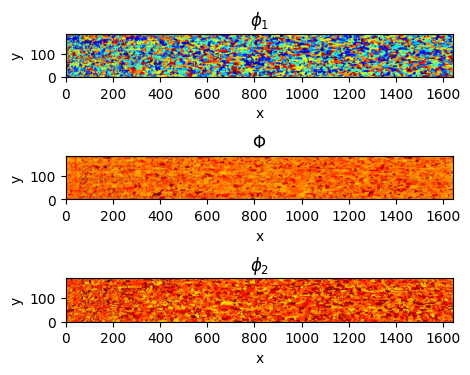

In [28]:
## 3개의 subplot 가진 캔버스 생성
fig,axes=gen_fig(ncols=1,nrows=3,colsize=5,rowsize=1.5)
labs=[r'$\phi_1$',r'$\Phi$',r'$\phi_2$']
#for i, ang in enumerate(euler_angles[:]):
for i, ang in enumerate(euler_angles[:]):
    ax=fig.axes[i]
    mappable=ax.imshow(ang,extent=(x0,x1,y0,y1),cmap='jet') ## color map?
    #ax.set_xticks(np.arange(0,400,100))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(labs[i])

## Making sure the orientations are correctly given

 이 코드는 orientation 데이터를 500개 무작위 추출하고, 그 위치를 시각화한 뒤, EVPSC(Elastic-viscoplastic Self-Consistent) 형식에 맞게 파일로 저장하기 위한 준비 과정을 포함.

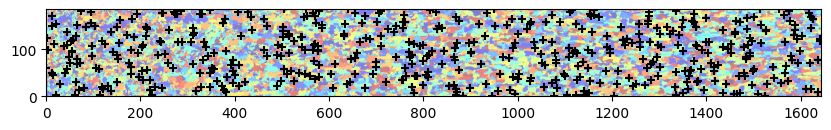

In [29]:
## random sampling
nsample=500
subdat=dat_ori[:,np.random.choice(dat_ori.shape[1], nsample, replace=False)]
points=subdat[3:5,:]

## showing where the orientation was 'sampled'
fig,axes=gen_fig(ncols=1,nrows=1,colsize=10,rowsize=5.0)
ax=axes[0,0]
ax.imshow(phi1,extent=(x0,x1,y0,y1),cmap='jet',alpha=0.5)
ax.scatter(*points,marker='+',c='k',s=30)

## writing down the sampled orientation to a file.
## The format follows that of (E)VPSC:

# It has four header lines, with the fourth has the 'B' for Bunge convention
# and the number of sampled orientations
# the remaining rows list the euler angles (phi1, phi, phi2, weight).
# Here we assign uniform weight for each sample.

## Adjust the orientation

입력된 방향 데이터(subdat)로부터 추출한 결정 방위(discrete orientation)를 바탕으로 pole figure(극점도) 작성.

Elapsed time for calling cells_pf:          54 [ ms]

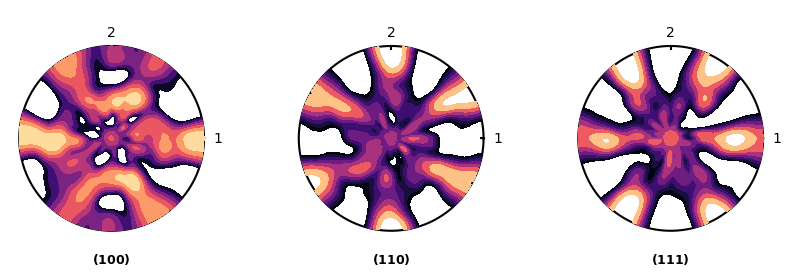

In [30]:
fnout=tempfile.mktemp()
with open(fnout,'w') as fo:
  fo.write(f'\n\n\nB {nsample}\n')
  for i in range(nsample):
    entry=subdat[:3,i]*180/np.pi ## from radian to degree
    fo.write("%f %f %f 1.0 \n"%(entry[0],entry[1],entry[2]))
mypf=upf.polefigure(filename=fnout,csym='cubic',cdim=[1,1,1],cang=[90,90,90])
fig=mypf.pf_new(poles=[[1,0,0],[1,1,0],[1,1,1]],ismooth=10,mode='contour')

pole figure를 다른 좌표계 기준으로 바꿔서 시각화.

Elapsed time for calling cells_pf:          54 [ ms]

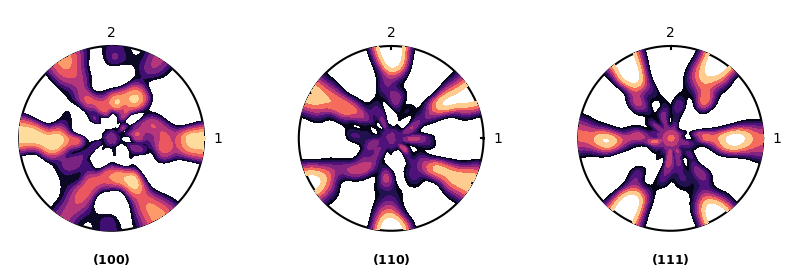

In [31]:
new1=[1,0,0]
new2=[0,0,-1]
new3=np.cross(new1,new2)
chgb=np.array([new1,new2,new3])
fig=mypf.pf_new(poles=[[1,0,0],[1,1,0],[1,1,1]],
                ismooth=10,transform=chgb,mn=0.8,mode='contour')

# Stitching

### Read and store data

데이터 읽기 및 저장

다음 셀은 특정 디렉토리에 존재하는 '.ang' 파일을 읽고, 그 안의 결정 방향 데이터를 추출하여 배열에 저장하는 셀.

In [32]:
## read data from files
fns=glob(os.path.join(tmp_dir,'FBW00*.ang'))
dat_oris=np.empty(len(fns),dtype='object')
phis=np.empty((len(fns),3),dtype='object')
Xs=np.empty(len(fns),dtype='object')
Ys=np.empty(len(fns),dtype='object')
nxs=np.empty(len(fns),dtype='object')
nys=np.empty(len(fns),dtype='object')
xys=np.empty((len(fns),2,2),dtype='object')
eulangs=np.empty(len(fns),dtype='object')
for i, fn in enumerate(fns):
    print(f'{i}-th filename: {fn}')
    #dat_ori=np.loadtxt(f"{fn}",skiprows=35).T
    dat_ori=pd.read_csv(fn,skiprows=35,sep=r'\s+',header=None)
    nx,ny,X,Y,phi1,Phi,phi2,x0,x1,y0,y1,euler_angles=read_euler_from_array(dat_ori)
    nxs[i]=nx
    nys[i]=ny
    ## store results
    eulangs[i]=euler_angles
    dat_oris[i]=dat_ori
    phis[i,:]=phi1,Phi,phi2
    xys[i,0]=x0,x1
    xys[i,1]=y0,y1
    Xs[i]=X
    Ys[i]=Y

0-th filename: /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_BM.ang
dat_ori.shape: (1219476, 10)
x range: 0.0 - 1643.0
y range: 0.0 - 185.0
nline_x: 3287
nline_y: 371
1-th filename: /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_WZ.ang
dat_ori.shape: (619198, 10)
x range: 0.0 - 834.0
y range: 0.0 - 185.0
nline_x: 1669
nline_y: 371
2-th filename: /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_WT.ang
dat_ori.shape: (2259674, 10)
x range: 0.0 - 373.0
y range: 0.0 - 1512.0
nline_x: 747
nline_y: 3025
3-th filename: /var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_HAZ.ang
dat_ori.shape: (478960, 10)
x range: 0.0 - 645.0
y range: 0.0 - 185.0
nline_x: 1291
nline_y: 371


### Analysis

다음 셀은 위의 셀에서 추출한 Euler 각도 데이터를 시각화하기 위한 캔버스를 만들고, 각도를 색상과 등고선 그래프로 subplot에 그리는 작업.

fn:/var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_BM.ang
fn:/var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_WZ.ang
fn:/var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_WT.ang
fn:/var/folders/wk/hzpfbtqd26z_swnn6msrj1y00000gn/T/tmpms4dc3bb/FBW00_HAZ.ang


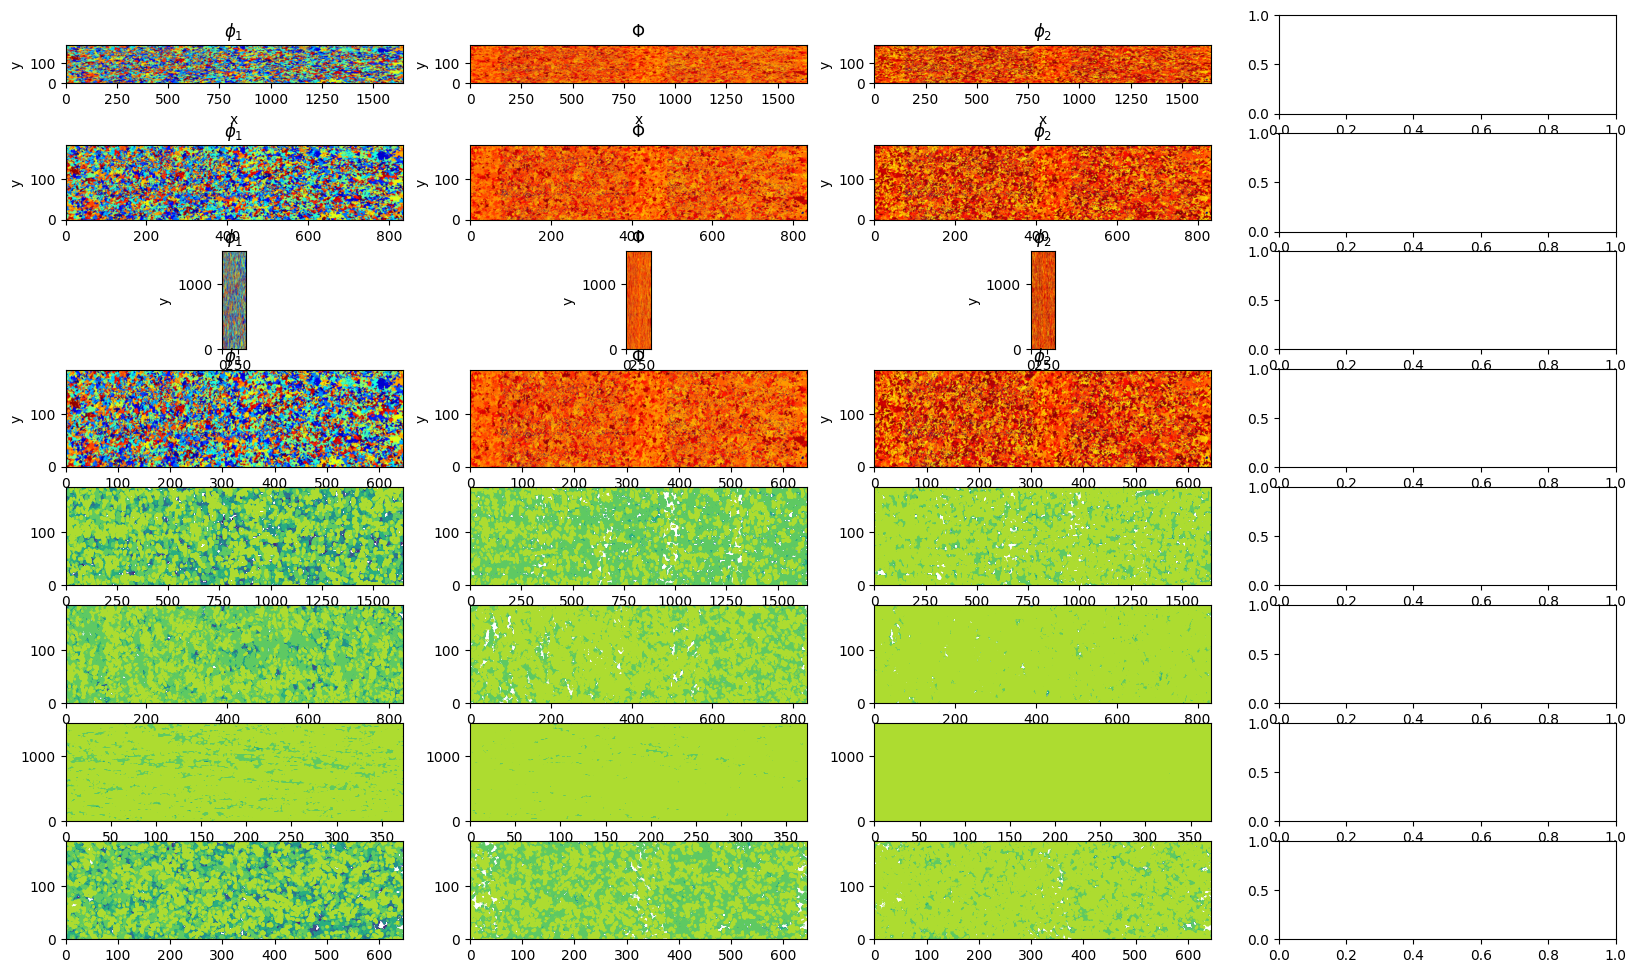

In [33]:
## 3개의 subplot 가진 캔버스 생성
fig,axes=gen_fig(ncols=len(fns),nrows=4*2,colsize=5,rowsize=1.5)
labs=[r'$\phi_1$',r'$\Phi$',r'$\phi_2$']

for j,fn in enumerate(fns):
    print(f'fn:{fn}')
    x0,x1=xys[j,0]
    y0,y1=xys[j,1]
    ang=eulangs[j]
    X,Y=Xs[j],Ys[j]
    phi1,Phi,phi2=phis[j]
    for i, ang in enumerate(euler_angles[:]):
        ang=ang*180/np.pi
        ax=axes[j,i]
        mappable=ax.imshow(ang,extent=(x0,x1,y0,y1),cmap='jet') ## color map?
        #ax.set_xticks(np.arange(0,400,100))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(labs[i])
        ax=axes[j+4,i]
        ax.contour(X,Y,[phi1,Phi,phi2][i])

### Manual stitching

다음 코드는 3개의 subplot을 가진 matplotlib figure를 생성하고, 각 subplot에 데이터 시각화를 수행하는 Python 스크립트. 주로 결정방위(Euler angles)와 관련된 데이터를 시각화하는 용도로 보이며, 특정 위치 데이터(X, Y)와 결정방위 각도(phi1, Phi, phi2)를 기반으로 정보를 표시.

X.shape: (371, 3287)
fn: FBW00_BM.ang, with x ranges of 0.0,1643.0, and y of 0.0,185.0
X.shape: (371, 1669)
fn: FBW00_WZ.ang, with x ranges of 0.0,834.0, and y of 0.0,185.0
X.shape: (3025, 747)
fn: FBW00_WT.ang, with x ranges of 0.0,373.0, and y of 0.0,1512.0
X.shape: (371, 1291)
fn: FBW00_HAZ.ang, with x ranges of 0.0,645.0, and y of 0.0,185.0


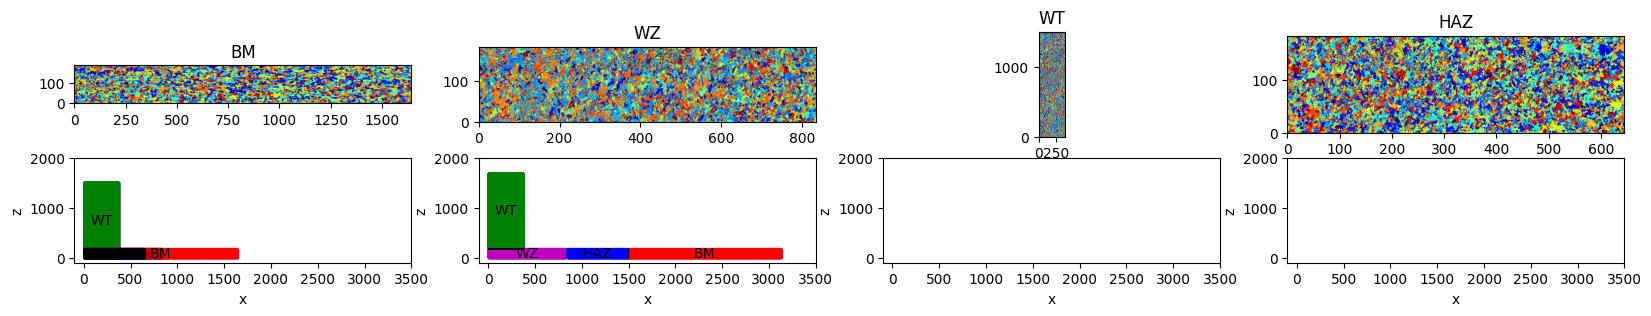

In [34]:
## 3개의 subplot 가진 캔버스 생성
fig,axes=gen_fig(ncols=len(fns),nrows=2,colsize=5,rowsize=1.5)
labs=[r'$\phi_1$',r'$\Phi$',r'$\phi_2$']
for j,fn in enumerate(fns):
    lab=os.path.split(fn)[-1].split('_')[-1].split('.ang')[0]
    x0,x1=xys[j,0]
    y0,y1=xys[j,1]
    ang=eulangs[j]
    dat_ori=dat_oris[j]
    X,Y=Xs[j].copy(),Ys[j].copy()
    phi1,Phi,phi2=phis[j]
    print(f'X.shape: {X.shape}')
    print(f'fn: {os.path.split(fn)[-1]}, with x ranges of {x0},{x1}, and y of {y0},{y1}')
    #for i, ang in enumerate(euler_angles[:1]): ## only phi1 contour is given.

    ax=axes[0,j]
    ax.set_title(lab)
    mappable=ax.imshow(ang[0],extent=(x0,x1,y0,y1),cmap='jet') ## color map?
    ax=axes[1,0]
    xavg,yavg=X.mean(),Y.mean()

    ##
    kw=dict(alpha=0.1,s=0.0005)
    kw.update(c=['r','m','g','b'][j])
    ax.scatter(X,Y,**kw)
    ax.text(xavg,yavg,lab,va='center',ha='center')

    ax=axes[1,1]
    if j==0: ## BM
        X=X+1490
    if j==1: ## WZ
        pass
    if j==2: ## WT
        Y=Y+185
    if j==3: ## HAZ
        X=X+845
    xavg,yavg=X.mean(),Y.mean()
    ax.scatter(X,Y,**kw)
    ax.text(xavg,yavg,lab,va='center',ha='center')
    #flt,rgbs=get_ipf_color(ang[0].flatten(),ang[1].flatten(),ang[2].flatten())
    #flt=flt.reshape(X.shape)
    #kw.update(c=rgbs)
    #print(f'len(flt): {len(flt)}')
    #axes[1,2].scatter(X[flt],Y[flt],**kw)

for i, ax in enumerate(axes[1,:]):
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_xlim(-100,3500); ax.set_ylim(-100,2000)

다음 코드는 dat_oris(data orientation) 리스트에 있는 여러 데이터셋의 크기(행 수)를 확인하고 출력하는 기본적인 분석 준비 단계.

In [35]:
for i, dat_ori in enumerate(dat_oris):
    dat_ori=dat_ori.to_numpy()
    ndatpoint=dat_ori.shape[0]
    print(f'{i+1}-th data analysis, # of data points: {ndatpoint}')
    #ndstep = int(ndatpoint/dmxn)

1-th data analysis, # of data points: 1219476
2-th data analysis, # of data points: 619198
3-th data analysis, # of data points: 2259674
4-th data analysis, # of data points: 478960


다음 코드는 orientation 데이터를 읽고, 그 데이터를 Euler 각도로부터 pole figure를 생성한 후, 각 영역의 위치에 색깔을 입힌 점들을 시각화하는 전처리.

1-th data analysis, # of data points: 1219476
   ndstep:  1219
** Er: # of failed: 26, fraction:   2.6 %
2-th data analysis, # of data points: 619198
   ndstep:  619
** Er: # of failed: 44, fraction:   4.4 %
3-th data analysis, # of data points: 2259674
   ndstep:  2259
** Er: # of failed: 64, fraction:   6.4 %
4-th data analysis, # of data points: 478960
   ndstep:  478
** Er: # of failed: 57, fraction:   5.7 %


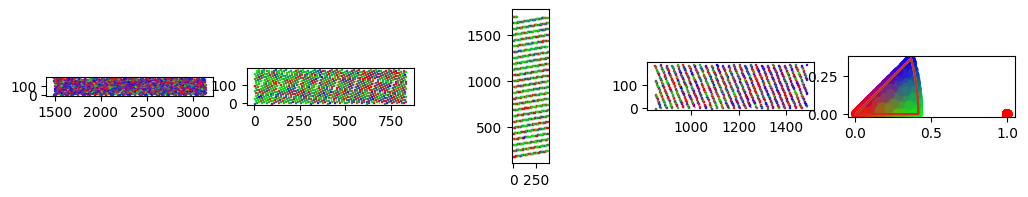

In [36]:
dmxn=1000 ## max data points per each dat_ori in dat_oris
fig,axes=gen_fig(ncols=len(dat_oris)+1,nrows=1)
for i, dat_ori in enumerate(dat_oris):

    dat_ori=dat_ori.to_numpy()
    ndatpoint=dat_ori.shape[0]
    print(f'{i+1}-th data analysis, # of data points: {ndatpoint}')
    ndstep = int(ndatpoint/dmxn)
    print(f'   ndstep:  {ndstep}')

    phi1s=dat_ori[::ndstep,0]
    Phis =dat_ori[::ndstep,1]
    phi2s=dat_ori[::ndstep,2]
    Xs   =dat_ori[::ndstep,3]
    Ys   =dat_ori[::ndstep,4]
    phi1s=np.rad2deg(phi1s)
    Phis=np.rad2deg( Phis)
    phi2s=np.rad2deg(phi2s)

    rst=get_pole_from_euler(phi1s,Phis,phi2s,pole_sa=[1,0,0],
                            fnsx='/Users/parkjaeseob/texture3/eddq.sx')
    projected_poles,rgbs,triangle,dat_selected = rst[0],rst[1],rst[2],rst[3]
    X=dat_selected[:,0]; Y=dat_selected[:,1]     ## projected poles onto (X,Y) plane
    rgbs=dat_selected[:,2:5]
    if True:
        if i==0: ## BM
            Xs=Xs+1490
        if i==1: ## WZ
            pass
        if i==2: ## WT
            Ys=Ys+185
        if i==3: ## HAZ
            Xs=Xs+845
        for j, ax in enumerate(axes[:1,i]):
            ax.scatter(Xs,Ys,c=rgbs,s=0.5,marker='s')
        #axes[1,0].scatter(Xs,Ys,c=rgbs,s=0.5,marker='s')

        #if i==0:
        axes[0,-1].plot(*triangle)
        axes[0,-1].scatter(X,Y,c=rgbs)
        for j, ax in enumerate(axes[:2,:].flatten()):
            ax.set_aspect('equal')

다음 코드는 dat_oris라는 orientation 데이터들에서 Euler 각도(phi1, Phi, phi2)를 meshgrid 위에 맵핑(interpolation) 하고, 이를 바탕으로 IPF 색상으로 표현한 맵을 시각화하는 과정.(! 연산자는 Python에서 쉘 명령어를 실행하는 것.)

* meshgrid: 2차원 공간 상에 정사각형 격자 좌표를 만들어주는 도구.
* 맵핑: 한 위치에서의 orientation 값을 해당 좌표에 색상이나 값으로 매겨주는 과정.
* IPF 색상: 각 위치의 결정 방향성을 RGB 색으로 바꾸는 과정.

x0, x1: (np.float64(0.0), np.float64(1643.0))
y0, y1: (np.float64(0.0), np.float64(185.0))
phi1.shape: (101, 100)
** Er: # of failed: 301, fraction:   3.0 %
x0, x1: (np.float64(0.0), np.float64(834.0))
y0, y1: (np.float64(0.0), np.float64(185.0))
phi1.shape: (101, 100)
** Er: # of failed: 404, fraction:   4.0 %
x0, x1: (np.float64(0.0), np.float64(373.0))
y0, y1: (np.float64(0.0), np.float64(1512.0))
phi1.shape: (101, 100)
** Er: # of failed: 649, fraction:   6.4 %
x0, x1: (np.float64(0.0), np.float64(645.0))
y0, y1: (np.float64(0.0), np.float64(185.0))
phi1.shape: (101, 100)
** Er: # of failed: 544, fraction:   5.4 %


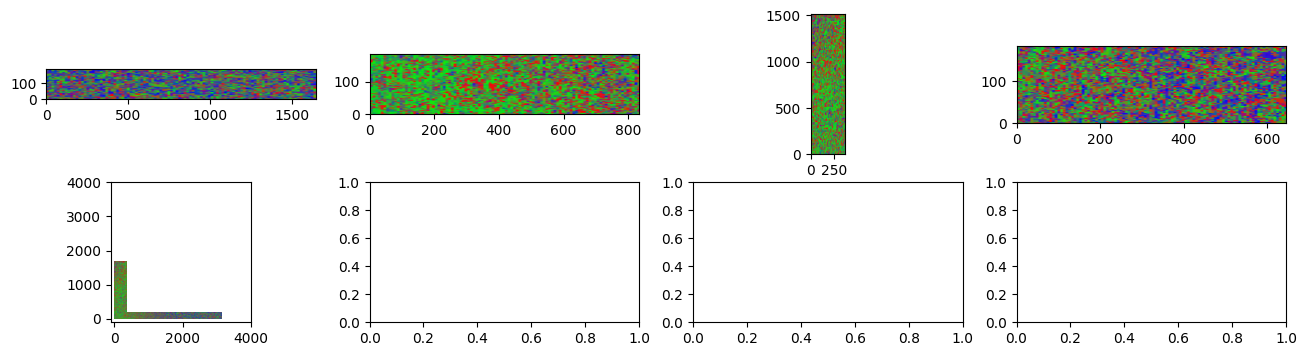

In [37]:
fig,axes=gen_fig(ncols=len(dat_oris),nrows=2,colsize=4)
dxys=np.zeros((len(dat_oris),2))
for i, dat_ori in enumerate(dat_oris):
    x=dat_ori[3]
    y=dat_ori[4]
    dx=find_dx(x)
    dy=find_dx(y)
    dxys[i,:]=dx,dy
    x0,x1=x.min(),x.max()
    y0,y1=y.min(),y.max()
    print(f'x0, x1: {x0,x1}')
    print(f'y0, y1: {y0,y1}')
    nline_x=int((x1-x0)/dx)+1
    nline_y=int((y1-y0)/dy)+1
    nline_x=100
    nline_y=101
    xs=np.linspace(x0,x1,nline_x)
    ys=np.linspace(y0,y1,nline_y)

    ## meshgrid
    X,Y=np.meshgrid(xs,ys)#,dtype='float16')
    points=np.array([x,y]).T
    ## meshgrid에 'nearest' interpolation 적용하여 (phi1, Phi, phi2)
    ## map 만들기.
    phi1=griddata(points,np.rad2deg(dat_ori[0]),(X,Y),method='nearest') #phi1
    Phi =griddata(points,np.rad2deg(dat_ori[1]),(X,Y),method='nearest') #Phi
    phi2=griddata(points,np.rad2deg(dat_ori[2]),(X,Y),method='nearest') #phi2
    print(f'phi1.shape: {phi1.shape}')
    rst=get_pole_from_euler(phi1.flatten(),Phi.flatten(),phi2.flatten(),
                            pole_sa=[0,0,1])
    dat=rst[3]
    rgbs=dat[:,2:5]
    rgbs=rgbs.reshape(*phi1.shape,3)
    #rgbs[rgbs>1]=1
    #rgbs[rgbs<0]=0
    #axes[0,i].imshow(phi1,extent=(x0,x1,y0,y1),cmap='jet')
    #axes[1,i].imshow(Phi,extent=(x0,x1,y0,y1),cmap='jet')
    #axes[2,i].imshow(phi2,extent=(x0,x1,y0,y1),cmap='jet')
    axes[0,i].imshow(rgbs,extent=(x0,x1,y0,y1))
    if i==0: ## BM
        x0=x0+1490
        x1=x1+1490
    if i==1: ## WZ
        pass
    if i==2: ## WT
        y0=y0+185
        y1=y1+185
    if i==3: ## HAZ
        x0=x0+845
        x1=x1+845

    axes[1,0].imshow(rgbs,extent=(x0,x1,y0,y1))
    axes[1,0].set_xlim(-100,4000)
    axes[1,0].set_ylim(-100,4000)
fig.savefig('/tmp/dum.pdf')
!open /tmp/dum.pdf

다음 코드는 여러 개의 재료 영역에 대해 IPF 색상 맵을 그리고, 각 영역의 경계를 사각형으로 표시하며, 전체 영역을 감싸는 큰 사각형도 함께 그려주는 시각화 작업.

** Er: # of failed: 288, fraction:   2.9 %
x0, x1: (np.float64(1490.0), np.float64(3133.0))
y0, y1: (np.float64(0.0), np.float64(185.0))
** Er: # of failed: 391, fraction:   3.9 %
x0, x1: (np.float64(0.0), np.float64(834.0))
y0, y1: (np.float64(0.0), np.float64(185.0))
** Er: # of failed: 633, fraction:   6.3 %
x0, x1: (np.float64(0.0), np.float64(373.0))
y0, y1: (np.float64(185.0), np.float64(1697.0))
** Er: # of failed: 549, fraction:   5.5 %
x0, x1: (np.float64(834.0), np.float64(1479.0))
y0, y1: (np.float64(0.0), np.float64(185.0))


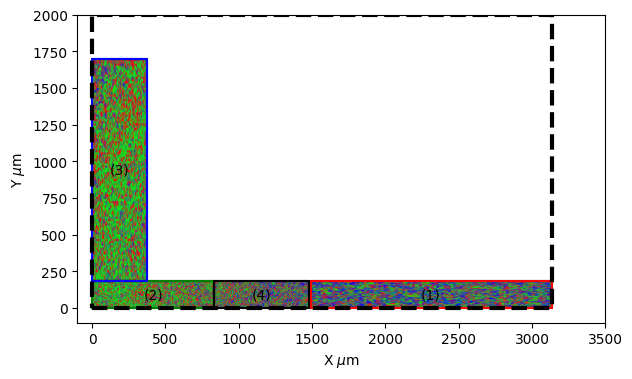

In [38]:
fig,axes=gen_fig(ncols=1,nrows=1,colsize=8,rowsize=4)

squares=np.zeros((len(dat_oris),2,5))
regions=dict()
for i, dat_ori in enumerate(dat_oris):
    x=dat_ori[3]; y=dat_ori[4]; dx=find_dx(x); dy=find_dx(y)
    x0,x1=x.min(),x.max(); y0,y1=y.min(),y.max()
    nline_x=int((x1-x0)/dx)+1
    nline_y=int((y1-y0)/dy)+1
    nline_x=100
    nline_y=100
    xs=np.linspace(x0,x1,nline_x)
    ys=np.linspace(y0,y1,nline_y)

    ## meshgrid
    X,Y=np.meshgrid(xs,ys)#,dtype='float16')
    points=np.array([x,y]).T
    ## meshgrid에 'nearest' interpolation 적용하여 (phi1, Phi, phi2)
    ## map 만들기.
    phi1=griddata(points,np.rad2deg(dat_ori[0]),(X,Y),method='nearest') #phi1
    Phi =griddata(points,np.rad2deg(dat_ori[1]),(X,Y),method='nearest') #Phi
    phi2=griddata(points,np.rad2deg(dat_ori[2]),(X,Y),method='nearest') #phi2
    #print(f'phi1.shape: {phi1.shape}')
    rst=get_pole_from_euler(phi1.flatten(),Phi.flatten(),phi2.flatten(),
                            pole_sa=[0,0,1])
    dat=rst[3]
    rgbs=dat[:,2:5]
    rgbs=rgbs.reshape(*phi1.shape,3)
    if i==0: ## BM
        x0=x0+1490
        x1=x1+1490
    if i==1: ## WZ
        pass
    if i==2: ## WT
        y0=y0+185
        y1=y1+185
    if i==3: ## HAZ
        x0=x0+834
        x1=x1+834
    print(f'x0, x1: {x0,x1}')
    print(f'y0, y1: {y0,y1}')
    ## draw square
    axes[0,0].plot([x0,x1,x1,x0,x0],[y0,y0,y1,y1,y0],'-k')
    squares[i,:]=gen_paths_square(x0,x1,y0,y1)
    axes[0,0].imshow(rgbs,extent=(x0,x1,y0,y1))


for i, sq in enumerate(squares):
    kw=dict(c=['r','g','b','k'][i])
    axes[0,0].plot(*sq,**kw)
    xav=sq[0,0:4].mean()
    yav=sq[1,0:4].mean()
    kw.update(ha='center',va='center',c='k')
    axes[0,0].text(xav,yav,f'({i+1})',**kw)

## big square
x0=squares[:,0].min()
x1=squares[:,0].max()
y0=squares[:,1].min()
y1=squares[:,1].max()

y1=2000
big_square=gen_paths_square(x0,x1,y0,y1)
axes[0,0].plot(*big_square,'--',lw=3,c='k')
axes[0,0].set_xlim(-100,3500)
axes[0,0].set_ylim(-100,y1)

axes[0,0].set_xlabel(r'X $\mu$m')
axes[0,0].set_ylabel(r'Y $\mu$m')
fig.savefig('/tmp/dum.pdf')
!open /tmp/dum.pdf

다음 코드는 dat_oris에 있는 여러 개의 결정 방향 데이터를 전처리해서, 각각의 데이터를 같은 형태(meshgrid 기준)로 변환하여 하나의 큰 배열(master_data)에 저장하는 작업.

In [39]:
master_data=np.empty((len(dat_oris),5),dtype='object') ## X, Y, phi1, Phi, phi2
for i, dat_ori in enumerate(dat_oris):
    x=dat_ori[3]; y=dat_ori[4]; dx=find_dx(x); dy=find_dx(y)
    x0,x1=x.min(),x.max(); y0,y1=y.min(),y.max()
    nline_x=int((x1-x0)/dx)+1
    nline_y=int((y1-y0)/dy)+1
    #nline_x=100
    #nline_y=100
    xs=np.linspace(x0,x1,nline_x)
    ys=np.linspace(y0,y1,nline_y)

    ## meshgrid
    X,Y=np.meshgrid(xs,ys)#,dtype='float16')
    points=np.array([x,y]).T
    ## meshgrid에 'nearest' interpolation 적용하여 (phi1, Phi, phi2)
    ## map 만들기.
    phi1=griddata(points,np.rad2deg(dat_ori[0]),(X,Y),method='nearest') #phi1
    Phi =griddata(points,np.rad2deg(dat_ori[1]),(X,Y),method='nearest') #Phi
    phi2=griddata(points,np.rad2deg(dat_ori[2]),(X,Y),method='nearest') #phi2
    print(f'{i+1}-th out of {len(dat_oris)}')
    master_data[i,:2]=X,Y
    master_data[i,2:]=phi1,Phi,phi2

1-th out of 4
2-th out of 4
3-th out of 4
4-th out of 4


다음 코드는 파일 경로 찾기.

In [40]:
fpath

'/Users/parkjaeseob/Downloads/project'

다음 코드는 여러 영역에서 추출한 결정 방향 데이터를 하나의 통합된 맵(EBSD 형식 .ang 파일)으로 변환하여 저장하는 과정. 전체적으로 매우 정교한 좌표 변환 및 보간 과정을 거치며, 각 픽셀의 Euler 각 정보를 정확히 맵핑하는 과정.

In [41]:
print('whole y range:',y1-y0)
print('whole x range:',x1-x0)

x0,x1=big_square[0,:].min(),big_square[0,:].max()#
y0,y1=big_square[1,:].min(),big_square[1,:].max()#
#if True:
if False:
    ndx=1000
    ndy=1000
    dy=(y1-y0)/ndy
    dx=(x1-x0)/ndx
else:
    dx=0.5
    dy=0.5
    ndx=int((x1-x0)/dx)
    ndy=int((y1-y0)/dy)

xs=np.linspace(x0,x1,ndx)
ys=np.linspace(y0,y1,ndy)
X,Y=np.meshgrid(xs,ys)
rgbs=np.empty((*X.shape,3))
print(X.shape)
print(Y.shape)

region=np.empty(X.shape,dtype='object')
reg_cs=region.copy()
## leave the below in this order.
region[Y>=185]='(3)'
reg_cs[Y>=185]='b'
region[Y<185]='(2)'
reg_cs[Y<185]='g'
region[X>373]='(2)'
reg_cs[X>373]='g'
region[X>834]='(4)'
reg_cs[X>834]='k'
region[X>1490]='(1)'
reg_cs[X>1490]='r'


fn_combined=os.path.join(fpath,'combined_map.ang')
fo=open(fn_combined,'w')
fmts='%11s'*5
fmts=f'{fmts}\n'
fo.write(fmts%('X','Y','phi1','Phi','phi2'))

fmte='%11.3e'*5
fmte=f'{fmte}\n'

k=0
for iy in range(ndx):
    for ix in range(ndy):
        x=X[ix,iy]; y=Y[ix,iy]
        reg=region[ix,iy]
        c=reg_cs[ix,iy]
        i=int(reg[1])-1 ## file id

        dx=squares[i,0].max()-squares[i,0].min()
        dy=squares[i,1].max()-squares[i,1].min()
        n, xrem = get_quot_rem(x,dx)
        n, yrem = get_quot_rem(y,dy)
        #--------------------
        # indx, indy are the index of raw EBSD data
        dx,dy=dxys[i,:]
        indx, xr = get_quot_rem(xrem,dx)
        indy, yr = get_quot_rem(yrem,dy)
        #print(f'indx, indy: {indx,indy}')
        xmaster,ymaster=master_data[i,:2]
        phi1,Phi,phi2=master_data[i,2:]
        #print(x,y,xmaster[indy,indx], ymaster[indy,indx])
        # axes[0,0].text(x,y,s=reg,va='center',ha='center',c=c)
        if False:
            rst=get_pole_from_euler([phi1[indy,indx]],[Phi[indy,indx]],
                                    [phi2[indy,indx]],pole_sa=[0,0,1])
            dat=rst[3]
            rgb=dat[:,2:5]
            rgbs[ix,iy,:]=rgb[0,:]
        fo.write(fmte%(phi1[indy,indx],Phi[indy,indx],phi2[indy,indx],x,y))
        k=k+1

fo.close()

extent=(big_square[0,:].min(),big_square[0,:].max(),
        big_square[1,:].min(),big_square[1,:].max())
print(f'extent {extent}')

whole y range: 185.0
whole x range: 645.0
(4000, 6266)
(4000, 6266)
extent (np.float64(0.0), np.float64(3133.0), np.float64(0.0), np.float64(2000.0))


다음 코드는 큰 사각형 영역 (big_square)을 기준으로 격자 수를 계산하고, 그 격자의 일부 비율(fracts)만큼의 간격을 계산하여 샘플 개수(혹은 resolution)를 예측하거나 테스트용 grid를 구성할 때 쓰이는 예제.

In [42]:
x0,x1=big_square[0,:].min(),big_square[0,:].max()#
y0,y1=big_square[1,:].min(),big_square[1,:].max()#
print(x0,x1)
print(y0,y1)
delta=0.5

xlines=int((x1-x0)/delta)+1
ylines=int((y1-y0)/delta)+1

fracts=[0.001,0.002,0.01,0.02,0.05,0.10]
for i, frac in enumerate(fracts):
    xln,yln=int(xlines*frac),int(ylines*frac)
    print(xln,yln)


0.0 3133.0
0.0 2000.0
6 4
12 8
62 40
125 80
313 200
626 400


다음 코드는 EBSD(Electron Backscatter Diffraction) 데이터에서 추출된 결정 방향 정보(Euler angles)를 다양한 해상도(fraction)로 줄여서, 각 해상도에 대해 Orientation Map (IPF) 및 Pole Figure (PF) 를 시각화하고, 결과를 텍스트 파일로 저장하는 코드.

dat_ori.shape: (5, 25064000)
x range: 0.0 - 3133.0
y range: 0.0 - 2000.0
nline_x: 6
nline_y: 4
Elapsed time for calling cells_pf:           5 [ ms]dat_ori.shape: (5, 25064000)
x range: 0.0 - 3133.0
y range: 0.0 - 2000.0
nline_x: 12
nline_y: 8
** Er: # of failed: 8, fraction:   8.3 %
Elapsed time for calling cells_pf:          12 [ ms]dat_ori.shape: (5, 25064000)
x range: 0.0 - 3133.0
y range: 0.0 - 2000.0
nline_x: 62
nline_y: 40
** Er: # of failed: 101, fraction:   4.1 %
Elapsed time for calling cells_pf:         255 [ ms]dat_ori.shape: (5, 25064000)
x range: 0.0 - 3133.0
y range: 0.0 - 2000.0
nline_x: 125
nline_y: 80
** Er: # of failed: 421, fraction:   4.2 %
Elapsed time for calling cells_pf:           1 [sec]dat_ori.shape: (5, 25064000)
x range: 0.0 - 3133.0
y range: 0.0 - 2000.0
nline_x: 313
nline_y: 200
** Er: # of failed: 2681, fraction:   4.3 %
Elapsed time for calling cells_pf:           6 [sec]dat_ori.shape: (5, 25064000)
x range: 0.0 - 3133.0
y range: 0.0 - 2000.0
nline_x: 62

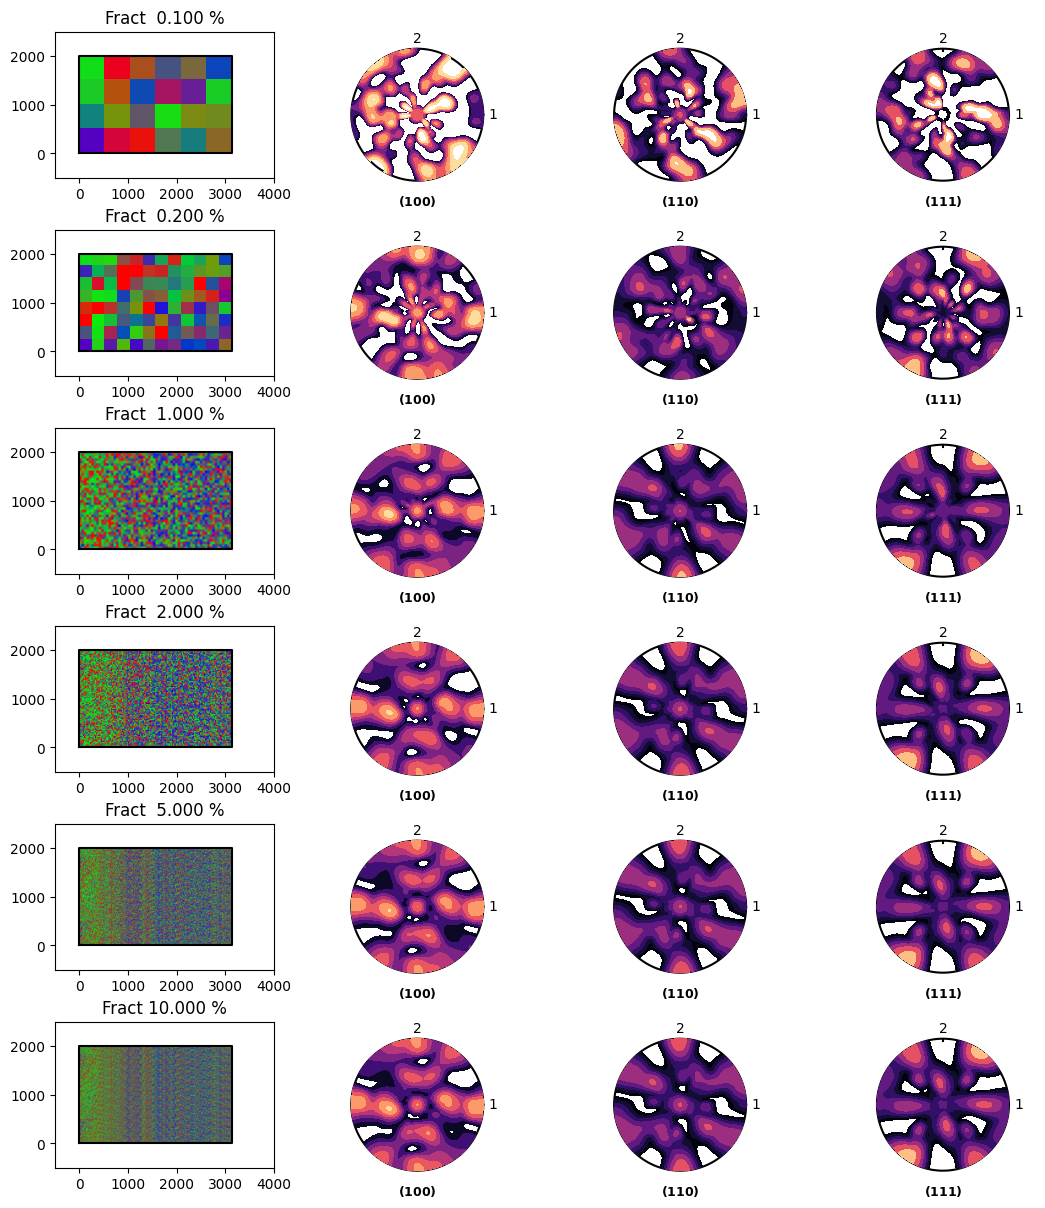

In [43]:
dat_combined=np.loadtxt(fn_combined,skiprows=1).T
X,Y,phi1,Phi,phi2=dat_combined

size=2.5
fig,axes=gen_fig(ncols=4,nrows=len(fracts),colsize=size*1.3,rowsize=size)


fns_fract=[]
for i, frac in enumerate(fracts):
    nline_x,nline_y=int(xlines*frac),int(ylines*frac)
    ## fraction of original data array "dat_combined".
    rst=read_euler_from_array(dat_combined,nline_x=nline_x,nline_y=nline_y)
    nline_x,nline_y,X,Y,phi1,Phi,phi2,x0,x1,y0,y1,euler_angles=rst
    shape=phi1.shape
    ngrs=len(phi1.flatten())
    grains=np.zeros((ngrs,4))
    grains[:,0]=phi1.flatten()
    grains[:,1]=Phi.flatten()
    grains[:,2]=phi2.flatten()
    grains[:,3]=1./ngrs
    rst=get_pole_from_euler(grains[:,0],grains[:,1],grains[:,2],
                            pole_sa=[0,0,1],fnsx='/Users/parkjaeseob/texture3/eddq.sx')
    dat=rst[3];rgb=dat[:,2:5]
    rgb=rgb.reshape((*shape,3))

    axes[i,0].plot(*big_square,'-k')
    axes[i,0].imshow(rgb,extent=(x0,x1,y0,y1))
    axs=axes[i,1:4]#.flatten()
    mypf=upf.polefigure(grains=grains,fnsx='/Users/parkjaeseob/texture3/eddq.sx')
    fig_pf=mypf.pf_new(axs=axs,poles=[[1,0,0],[1,1,0],[1,1,1]],ismooth=10,mn=0.5,mx=3,mode='contour')

    fn_fract=f'data_fract_{frac}.txt'
    fns_fract.append(fn_fract)
    with open(fn_fract,'w') as fo:
        fmts='%11s'*5
        fmts=f'{fmts}\n'
        fo.write(fmts%('X','Y','phi1','Phi','phi2'))
        fmte='%11.3e'*5
        fmte=f'{fmte}\n'
        for indx in range(nline_x):
            for indy in range(nline_y):
                x=X[indy,indx]
                y=Y[indy,indx]
                fo.write(fmte%(phi1[indy,indx],Phi[indy,indx],phi2[indy,indx],x,y))

for i, ax in enumerate(axes[:,0]):
    ax.set_xlim(-500,4000)
    ax.set_ylim(-500,2500)
    ax.set_aspect('equal')
    ax.set_title(r'Fract %6.3f %%'%(fracts[i]*100))

fig.savefig('/tmp/ipf.pdf')
!open /tmp/ipf.pdf

다음 코드는 각 파일 fn에 대해 ls -lstrh 명령어를 실행하여 터미널에 출력하는 동작을 수행.ㄴ

In [44]:
for i, fn in enumerate(fns_fract):
    !ls -lstrh {fn}

8 -rw-r--r--@ 1 parkjaeseob  staff   1.4K May 26 13:32 data_fract_0.001.txt
16 -rw-r--r--@ 1 parkjaeseob  staff   5.3K May 26 13:32 data_fract_0.002.txt
392 -rw-r--r--@ 1 parkjaeseob  staff   136K May 26 13:32 data_fract_0.01.txt
1160 -rw-r--r--@ 1 parkjaeseob  staff   547K May 26 13:33 data_fract_0.02.txt
8200 -rw-r--r--@ 1 parkjaeseob  staff   3.3M May 26 13:33 data_fract_0.05.txt
28680 -rw-r--r--@ 1 parkjaeseob  staff    13M May 26 13:34 data_fract_0.1.txt


# validate upf package

phi1, phi, phi2 180 180 90
(10000, 2)


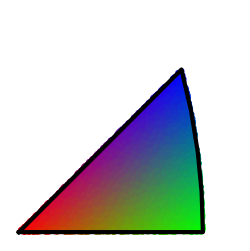

In [45]:
fig,axes=gen_fig(nrows=1,ncols=1,colsize=3,rowsize=3)
ax=axes[0,0]
## stereographic fundamental triangle
fnsx='/Users/parkjaeseob/texture3/eddq.sx'
triangle, a, b, c = upf.get_ipf_boundary(
    fnsx=fnsx)
ax.plot(*triangle)
# Generate a sample of random orientations.
grains=cmb.random(ngrain=10000,phi1=180,phi2=90,phi=180) #amat= upf.euler(phi1,Phi,phi2) # ca<-sa
XY, WGT, COL, projected_poles, nsymopx2 = upf.cells_pf(
    iopt=1,proj='ipf',pole=[1,0,0],csym='cubic',grains=grains)
#XY, WGT, COL = upf.cells_pf(iopt=1,proj='ipf',pole=[1,0,0],csym='cubic',grains=grains)
phi1s=grains[:,0]
Phis =grains[:,1]
phi2s=grains[:,2]

color_mapper=get_color_mapper(np.array(a),np.array(b),np.array(c))
#get_rgb_from_invp(projected_poles,color_mapper)
flt,rgbs=get_ipf_color(phi1s,Phis,phi2s)
#print(f'rgbs.shape: {rgbs.shape}')
#print(f'rgbs: {rgbs}')
## Plot the projected inverse poles
XY=XY[flt,:]
ax.scatter(XY[:,0],XY[:,1],c=rgbs,s=10)
ax.plot(*triangle,'-k',lw=3)
print(XY.shape)
ax.set_aspect('equal')
ax.set_xlim(-0.02,0.5)
ax.set_ylim(-0.02,0.5)
ax.set_axis_off()
ths=np.linspace(-np.pi,np.pi)
ax.plot(np.cos(ths),np.sin(ths),'-k')
#ax.plot(np.cos(ths)*np.sqrt(4),np.sin(ths)*np.sqrt(4),'--k')
#ax=axes[0,1]
#get_pole_from_euler(phi1s,Phis,phi2s,pole_sa=[1,0,0],fnsx=fnsx)
#ax=plt.gca()
#ax.set_aspect('equal')
#ax.set_xlim(-0.02,0.5)
#ax.set_ylim(-0.02,0.5)
#ax.plot(*triangle,'-r')

In [46]:
fntx='../../matData/vpscData/EDDQ/eddq_10000'
fnsx='/Users/parkjaeseob/texture3/eddq.sx'
poles=[[0,0,1],[1,1,0],[1,1,1]]
mypf=upf.polefigure(filename=fntx,fnsx=fnsx)
fig=mypf.pf_new(proj='pf',poles=poles,ismooth=10,mn=0.5)
fig=mypf.pf_new(proj='ipf',poles=[[0,0,1]],ismooth=10)

FileNotFoundError: [Errno 2] No such file or directory: '../../matData/vpscData/EDDQ/eddq_10000'

In [ ]:
ls ../../matData/vpscData/Al6061/texture/

Al6061.UXD*           Al6061_vpin_100.txt*  Al6061_vpin_6000.txt*
Al6061.epf*           Al6061_vpin_2000.txt*
Al6061_vpin.txt*      Al6061_vpin_500.txt*


amats.shape: (6000, 3, 3)
amats.shape: (6000, 3, 3)
amats.shape: (6000, 3, 3)
Elapsed time for calling cells_pf:         640 [ ms]amats.shape: (6000, 3, 3)
Elapsed time for calling cells_pf:           1 [sec]

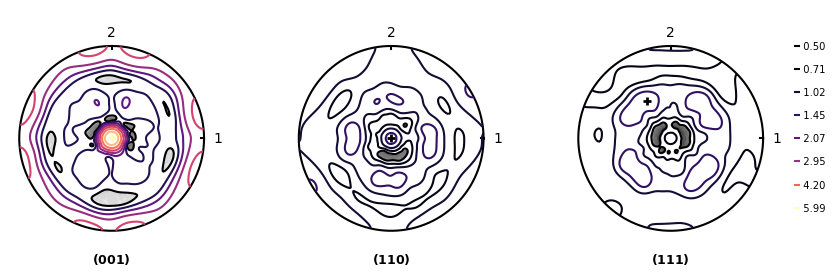

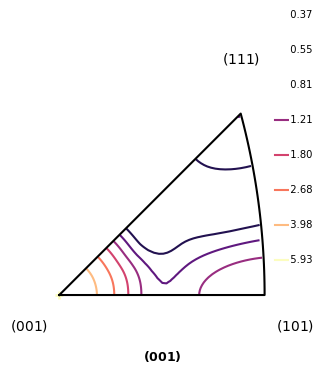

In [ ]:
fntx='../../matData/vpscData/Al6061/texture/Al6061_vpin_6000.txt'
fnsx='../../matData/vpscData/Al6061/sx/FCC_tangent_v4_80.sx'
poles=[[0,0,1],[1,1,0],[1,1,1]]
mypf=upf.polefigure(filename=fntx,fnsx=fnsx)
fig=mypf.pf_new(proj='pf',poles=poles,ismooth=10,mn=0.5)
fig=mypf.pf_new(proj='ipf',poles=[[0,0,1]],ismooth=10)


amats.shape: (5000, 3, 3)
amats.shape: (5000, 3, 3)
amats.shape: (5000, 3, 3)
Elapsed time for calling cells_pf:         309 [ ms]amats.shape: (5000, 3, 3)
amats.shape: (5000, 3, 3)
amats.shape: (5000, 3, 3)
Elapsed time for calling cells_pf:           2 [sec]

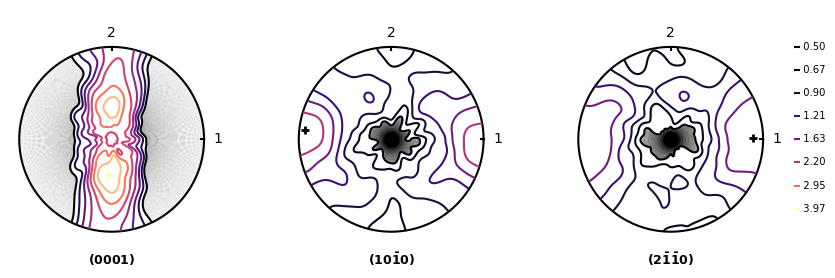

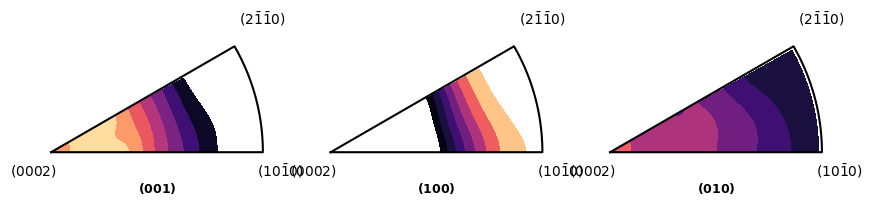

In [ ]:
fntx='../../matData/vpscData/CP-Ti-ICN/5000.tex'
fnsx='../../matData/vpscData/CP-Ti-ICN/dd_123.sx'
poles=[[0,0,0,1],[1,0,-1,0],[2,-1,-1,0]]
mypf=upf.polefigure(filename=fntx,fnsx=fnsx)
fig=mypf.pf_new(proj='pf',poles=poles,ismooth=10,mn=0.5)
fig=mypf.pf_new(proj='ipf',poles=[[0,0,1],[1,0,0],[0,1,0]],ismooth=10,mn=0,mode='contour')
